COMP S493F Project

Name: Li Wing On

SID: 12886461

Introduction:

In this deep learning project, there are two classification tasks using deep learnig solutions to develop.  

The first task is to design, implement, evaluate, and analyze 2 deep learning candidate models (1. mobilenet with transfer learning and 2. efficientnetV2 with transfer learning) for the CIFAR-100 subset.

Then evaluate which model have better preformance and use the better model preform task 2.

In second task, use my selfie image to preform binary classification. 12 images for happy class and 12 images for sad class.

## Utility code

In [1]:
ANIMALS_PEOPLE_INDICES = [
 1, 2, 3, 4, 6, 7,
 11, 14, 15, 18, 19,
 21, 24, 26, 27, 29,
 30, 31, 32, 34, 35, 36, 38,
 42, 43, 44, 45, 46,
 50, 55, 57,
 63, 64, 65, 66, 67,
 72, 73, 74, 75, 77, 78, 79,
 80,
 91, 93, 95, 97, 98, 99,
]
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt


def select_animals_people(y):
    """Returns a boolean mask for selecting animals/people in y"""
    return np.isin(np.ravel(y), ANIMALS_PEOPLE_INDICES)
def compress_animals_people_indices(y):
    """Maps indices in y to range 0 to 49"""
    out = np.zeros(100)
    for i, index in enumerate(ANIMALS_PEOPLE_INDICES):
        out[index] = i
    return out[y]
def load_cifar100_animals_people():
    """Loads a subset of CIFAR100 of animals and people"""
    (X_train, y_train), (X_test, y_test) = cifar100.load_data()
    mask_train = select_animals_people(y_train)
    X_train, y_train = X_train[mask_train], y_train[mask_train]
    mask_test = select_animals_people(y_test)
    X_test, y_test = X_test[mask_test], y_test[mask_test]
    y_train = compress_animals_people_indices(y_train)
    y_test = compress_animals_people_indices(y_test)
    return X_train, y_train, X_test, y_test


# Load and print sample data
X_train, y_train, X_test, y_test = load_cifar100_animals_people()

# Print the shapes of the training and test data
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Training data shape: (25000, 32, 32, 3)
Training labels shape: (25000, 1)
Test data shape: (5000, 32, 32, 3)
Test labels shape: (5000, 1)


Example for the dataset


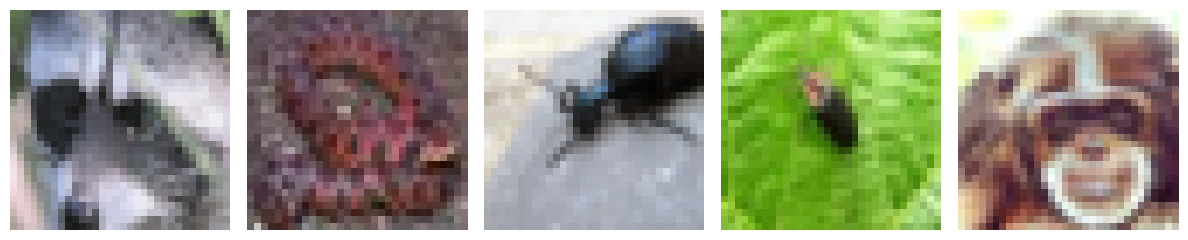

In [2]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2.5))
axes = axes.ravel()

# Display 5 random samples
for i in range(5):
    idx = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[idx])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

This function retrieves the final results in a training history, i.e. values of "loss", "val_loss", "acc", and "val_acc" in the final epoch.


In [3]:
def history_final_values(history):
    return {k: round(v[-1], 4) for k, v in history.history.items()}

This function plots a training history, including both training and validation results.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

def history_final_values(history):
    return {k: round(v[-1], 4) for k, v in history.history.items()}

def plot_history(history):
    df = pd.DataFrame(history.history)
    df.index = df.index + 1
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    df.plot(y=["loss", "val_loss"], grid=True, ax=axs[0])
    df.plot(y=["acc", "val_acc"], grid=True, ax=axs[1])
    plt.tight_layout()

This function compiles and fits a model, and returns the training history. Note that the number of epochs, batch size, ratio of validation split(80% training set: 20% validation set) are fixed in this function.

In [5]:
def compile_and_fit_model(model, X_train, y_train, epochs=20, batch_size=256, verbose=2):
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["acc"])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        verbose=verbose, callbacks=[early_stopping], validation_split=0.2)
    return history

## Task 1

## Candidate model 1 :

Mobilenet with transfer learning

Since there is not enough computation resourses in colab. I randomize the data set and select the first 10000 data for training and 2000 for testing.

First, preform one-hot encoding for the labels.

Then, the data preprocessing is finished before the transfer learning. Load the pretrained model of mobilenet and transfer learning.

layers.UpSampling2D(size=(4, 4)) times 4 times the input size (32 X 4) = 128 to match with the model input.

In the model, I added the dense layer with 1024 neurons and l1 regularization method and dropout(0.5) to regularize the complex model with softmax activition for output layer on 50 classes.

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import mobilenet
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


l1 = regularizers.l1(1e-7)

# Load data
X_train, y_train, X_test, y_test = load_cifar100_animals_people()

# Randomize training and test sets (keeping X-y pairs intact)
def randomize(X, y):
    indices = np.random.permutation(len(X))
    return X[indices], y[indices]

X_train, y_train = randomize(X_train, y_train)
X_test, y_test = randomize(X_test, y_test)

# Subset the data (40%)
X_train = X_train[:10000]
y_train = y_train[:10000]
X_test = X_test[:2000]
y_test = y_test[:2000]

# Convert labels to one-hot encoding for 50 classes
y_train = to_categorical(y_train, num_classes=50)
y_test = to_categorical(y_test, num_classes=50)

# Keep a copy of the raw data for display
X_train_display = X_train.copy()
X_test_display = X_test.copy()

# Upsample the display copy to match the model's input size (128x128)
X_test_display_upsampled = tf.image.resize(X_test_display, [128, 128]).numpy().astype(np.uint8)

X_train = mobilenet.preprocess_input(X_train)
X_test = mobilenet.preprocess_input(X_test)

base_model = mobilenet.MobileNet(weights="imagenet", include_top=False,
                                 input_shape=(128, 128, 3))
base_model.trainable = False
model = keras.Sequential([
    layers.UpSampling2D(size=(4, 4)),
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation="relu", activity_regularizer=l1),
    layers.Dropout(0.5),
    layers.Dense(50, activation="softmax")
])
model.summary()
#history = compile_and_fit_model(model, X_train, y_train, epochs=20)

#print(history_final_values(history))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ up_sampling2d_3 (UpSampling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_128 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [19]:
history = compile_and_fit_model(model, X_train, y_train, epochs=20)

print(history_final_values(history))

Epoch 1/20
32/32 - 15s - 463ms/step - acc: 0.1369 - loss: 5.7641 - val_acc: 0.3170 - val_loss: 2.7390
Epoch 2/20
32/32 - 2s - 75ms/step - acc: 0.3449 - loss: 2.4794 - val_acc: 0.4280 - val_loss: 2.1224
Epoch 3/20
32/32 - 2s - 75ms/step - acc: 0.4658 - loss: 1.9184 - val_acc: 0.4840 - val_loss: 1.9253
Epoch 4/20
32/32 - 2s - 76ms/step - acc: 0.5690 - loss: 1.4888 - val_acc: 0.4960 - val_loss: 1.7695
Epoch 5/20
32/32 - 3s - 80ms/step - acc: 0.6494 - loss: 1.1985 - val_acc: 0.5235 - val_loss: 1.6745
Epoch 6/20
32/32 - 2s - 75ms/step - acc: 0.7097 - loss: 0.9690 - val_acc: 0.5165 - val_loss: 1.7399
Epoch 7/20
32/32 - 3s - 82ms/step - acc: 0.7709 - loss: 0.7907 - val_acc: 0.5285 - val_loss: 1.6944
Epoch 8/20
32/32 - 5s - 157ms/step - acc: 0.8018 - loss: 0.6607 - val_acc: 0.5435 - val_loss: 1.6675
Epoch 9/20
32/32 - 2s - 74ms/step - acc: 0.8179 - loss: 0.5783 - val_acc: 0.5340 - val_loss: 1.7053
Epoch 10/20
32/32 - 3s - 85ms/step - acc: 0.8476 - loss: 0.5122 - val_acc: 0.5360 - val_loss: 1.7

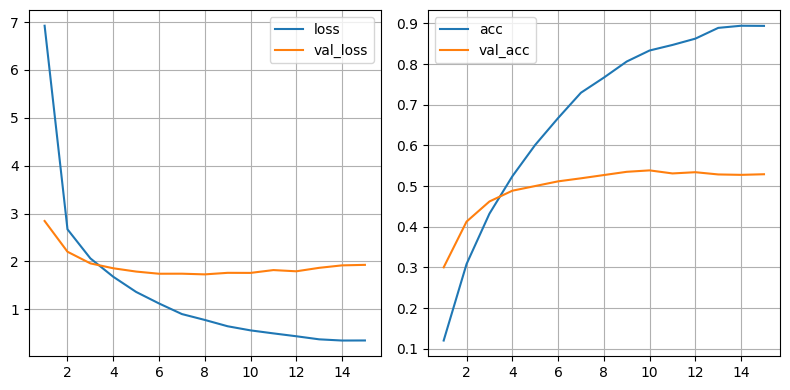

In [11]:
plot_history(history)

 Prediction using test set

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
Test set accuracy: 0.5500


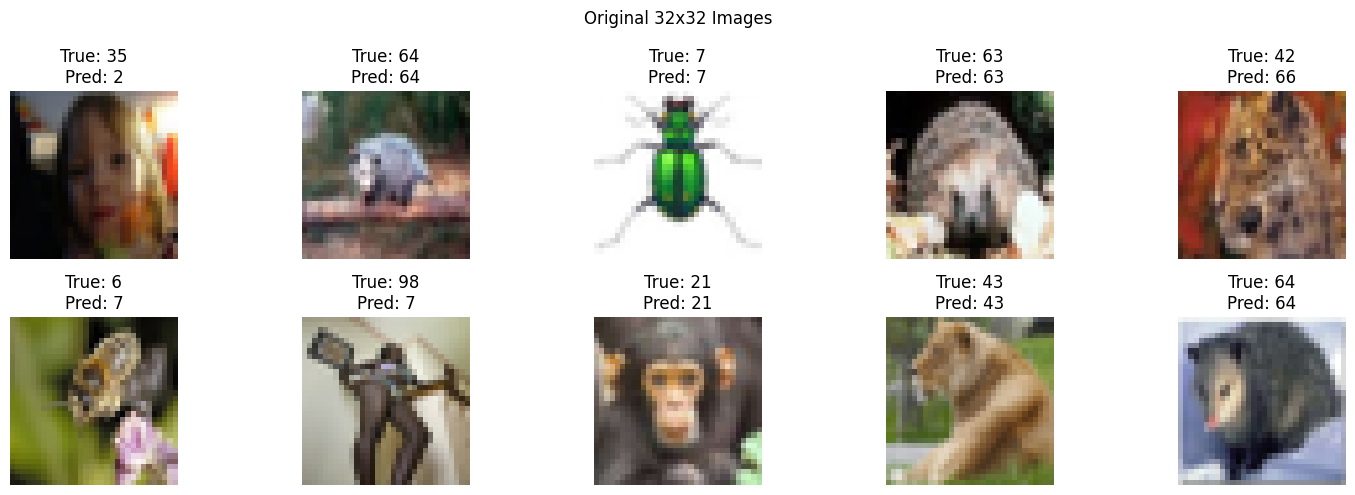

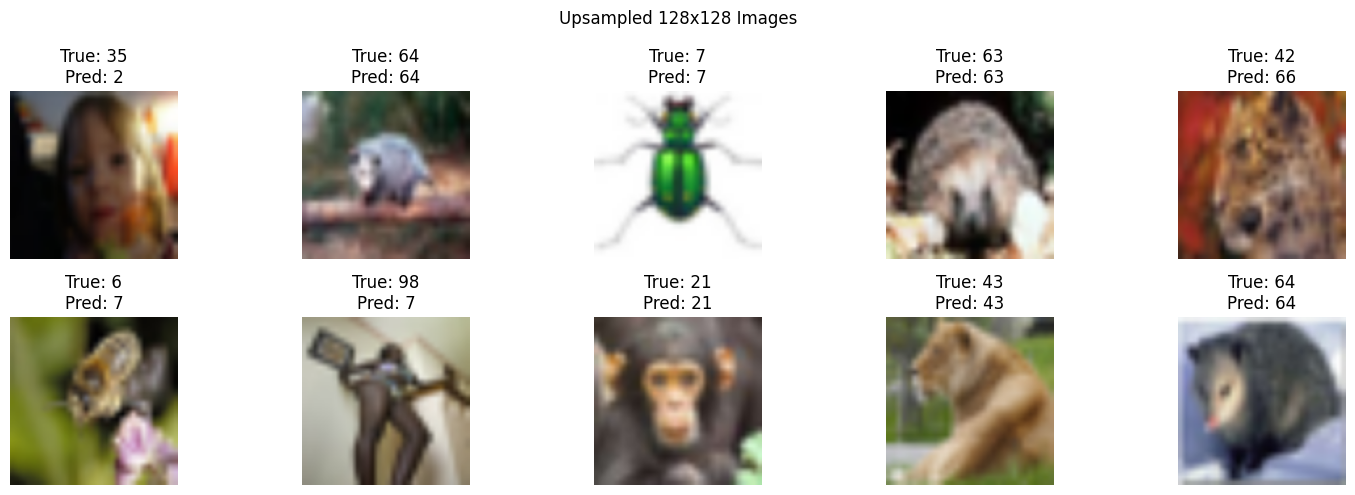

In [20]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate test accuracy
accuracy = np.mean(y_pred_classes == y_test_classes)
print(f"Test set accuracy: {accuracy:.4f}")

num_images = 10
plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test_display[i])
    plt.title(f"True: {ANIMALS_PEOPLE_INDICES[y_test_classes[i]]}\nPred: {ANIMALS_PEOPLE_INDICES[y_pred_classes[i]]}")
    plt.axis('off')
plt.suptitle("Original 32x32 Images")
plt.tight_layout()
plt.show()

# Display predictions with upsampled 128x128 images
plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test_display_upsampled[i])
    plt.title(f"True: {ANIMALS_PEOPLE_INDICES[y_test_classes[i]]}\nPred: {ANIMALS_PEOPLE_INDICES[y_pred_classes[i]]}")
    plt.axis('off')
plt.suptitle("Upsampled 128x128 Images")
plt.tight_layout()
plt.show()

Model Evaluation:

For the training set and validation set

{'acc': 0.8839, 'loss': 0.3635, 'val_acc': 0.5395, 'val_loss': 1.8304}

Prediction using test set

Test set accuracy: 0.5500  

## Candidate model 2 :

Efficientnet_v2

EfficientNetV2 is a update version of EfficientNet which is an advanced neural network architecture that often used in computer vision tasks. EfficientNetV2 achieves higher accuracy on image classification tasks while requiring fewer computational resources and less training time compare its previous version and other models like VGG.

[Reference website.](https://arxiv.org/abs/2104.00298)

For the second model, a pre-trained efficientnet_v2 is used.

Similarly, randomize the data set and select the first 10000 data for training and 2000 for testing and the data prepocessing to resize the input size to 96 that used for model input.

One-hot encoding are also.

base_model.trainable = False means that the the pre-trained model is freezed and not to train the parameters inside the basemodel.

In transfer learning model, I have added the data augmentation before the basemodel, dense layer after the basemodel with 128 neurons and dropout method to regularize the model. Finally, softmax activtion function for output layer with 50 classes.







In [69]:
import tensorflow as tf
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Load data
X_train, y_train, X_test, y_test = load_cifar100_animals_people()

# Randomize training and test sets (keeping X-y pairs intact)
def randomize(X, y):
    indices = np.random.permutation(len(X))
    return X[indices], y[indices]

X_train, y_train = randomize(X_train, y_train)
X_test, y_test = randomize(X_test, y_test)

# Subset the data
X_train = X_train[:10000]
y_train = y_train[:10000]
X_test = X_test[:2000]
y_test = y_test[:2000]

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=50)
y_test = to_categorical(y_test, num_classes=50)

# Preprocess and resize for EfficientNetV2
X_train_upsampled = tf.image.resize(X_train, [96, 96])  # EfficientNetV2B0 min size
X_test_upsampled = tf.image.resize(X_test, [96, 96])

X_train_preprocessed = efficientnet_v2.preprocess_input(X_train_upsampled)
X_test_preprocessed = efficientnet_v2.preprocess_input(X_test_upsampled)

# Build model
base_model = efficientnet_v2.EfficientNetV2B0(
    weights="imagenet",
    include_top=False,
    input_shape=(96, 96, 3)
)
base_model.trainable = False

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])
model = tf.keras.Sequential([
    data_augmentation,
    # Base model
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(50, activation="softmax")
])
model.summary()
#history = compile_and_fit_model(model, X_train_preprocessed, y_train, epochs=10)

#print(history_final_values(history))

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 3, 3, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [70]:
history = compile_and_fit_model(model, X_train_preprocessed, y_train, epochs=20)

print(history_final_values(history))

Epoch 1/20
32/32 - 22s - 688ms/step - acc: 0.1349 - loss: 3.5590 - val_acc: 0.3920 - val_loss: 2.7639
Epoch 2/20
32/32 - 4s - 134ms/step - acc: 0.3525 - loss: 2.5776 - val_acc: 0.5055 - val_loss: 1.9319
Epoch 3/20
32/32 - 4s - 139ms/step - acc: 0.4311 - loss: 2.1442 - val_acc: 0.5430 - val_loss: 1.7112
Epoch 4/20
32/32 - 4s - 114ms/step - acc: 0.4705 - loss: 1.9694 - val_acc: 0.5645 - val_loss: 1.6028
Epoch 5/20
32/32 - 5s - 164ms/step - acc: 0.4871 - loss: 1.8496 - val_acc: 0.5795 - val_loss: 1.5552
Epoch 6/20
32/32 - 4s - 111ms/step - acc: 0.5109 - loss: 1.7731 - val_acc: 0.5750 - val_loss: 1.5131
Epoch 7/20
32/32 - 6s - 181ms/step - acc: 0.5296 - loss: 1.7067 - val_acc: 0.5825 - val_loss: 1.4928
Epoch 8/20
32/32 - 4s - 137ms/step - acc: 0.5431 - loss: 1.6432 - val_acc: 0.5915 - val_loss: 1.4649
Epoch 9/20
32/32 - 4s - 129ms/step - acc: 0.5481 - loss: 1.6130 - val_acc: 0.5895 - val_loss: 1.4541
Epoch 10/20
32/32 - 4s - 138ms/step - acc: 0.5561 - loss: 1.5820 - val_acc: 0.5975 - val_l

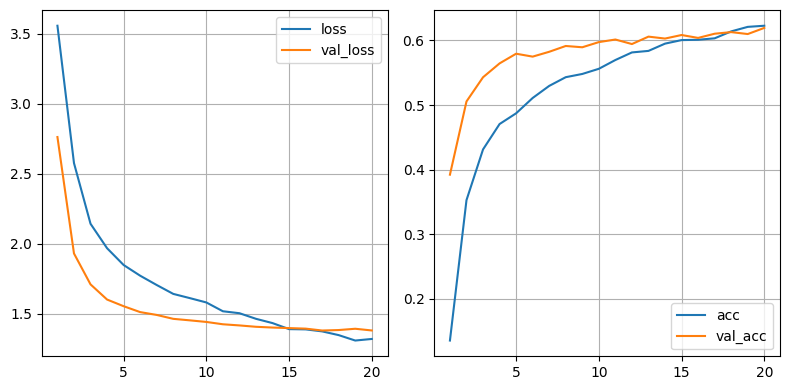

In [71]:
plot_history(history)

Prediction using test set X_test and y_test

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step
Test set accuracy: 0.6100
X_test_display range: 0 255


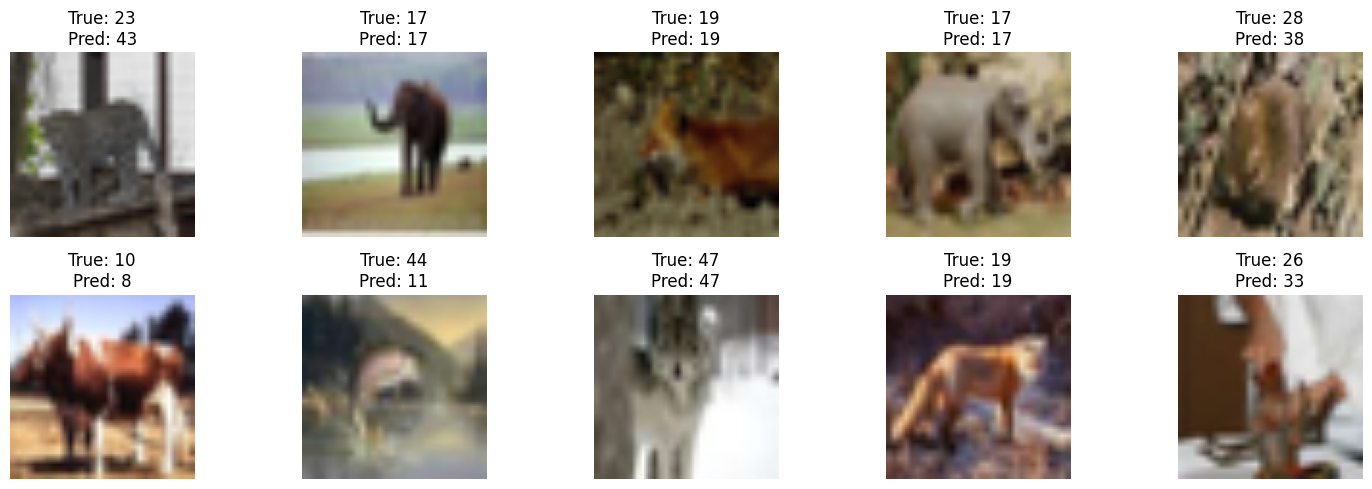

In [72]:
# Make predictions
y_pred = model.predict(X_test_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred_classes == y_test_classes)
print(f"Test set accuracy: {accuracy:.4f}")

# Use the upsampled X_test for display (already in [0, 255])
X_test_display = X_test_upsampled.numpy().astype(np.uint8)


print("X_test_display range:", X_test_display.min(), X_test_display.max())

# Plot some example predictions with images
num_images = 10
plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test_display[i])
    plt.title(f"True: {y_test_classes[i]}\nPred: {y_pred_classes[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Model evaluation:

The result using training set and validation set is

{'acc': 0.6229, 'loss': 1.3212, 'val_acc': 0.6195, 'val_loss': 1.3819}

The result of the prediction using test set

Test set accuracy: 0.6100

## Recommandation

Althought the test set accuracy of both model are similar (mobilenet: 0.5500 and efficientnet_v2: 0.6100), the preformance of efficientnet_v2 is slightly higher.

Additionally, the range of acc and val_acc, loss and val_loss of mobilemet is large which may consider as overfitting.

{'acc': 0.8839, 'loss': 0.3635, 'val_acc': 0.5395, 'val_loss': 1.8304}

But in efficientnet_v2, the differences are small.

{'acc': 0.6229, 'loss': 1.3212, 'val_acc': 0.6195, 'val_loss': 1.3819}

Therefore, model 2 (efficientnet_v2) is used for task 2.





## Task 2

The following code connects to the Google drive and mounts it to the directory "/content/drive" of the Colab VM. The try-catch construct handles the error when the notebook is executed in a non-Colab environment.

In [43]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    CATS_ZIP = "/content/drive/MyDrive/happy12.zip"
    DOGS_ZIP = "/content/drive/MyDrive/sad12.zip"
    DATASET_DIR = "/content/happy_and_sad_12.zip"
except:
    CATS_ZIP = "./happy12.zip"
    DOGS_ZIP = "./sad12.zip"
    DATASET_DIR = "./happy_and_sad_12"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, the images in the two zip files are extracted to the dataset directory. The sub-directory names, "cat" and "dog", will be the class names of the labels when the dataset is loaded.

In [47]:
!mkdir -p "$DATASET_DIR/happy"
!mkdir -p "$DATASET_DIR/sad"
!unzip -j -q -o "$CATS_ZIP" -d "$DATASET_DIR/happy"
!unzip -j -q -o "$DOGS_ZIP" -d "$DATASET_DIR/sad"
!ls -R "$DATASET_DIR"

/content/happy_and_sad_12.zip:
happy  sad

/content/happy_and_sad_12.zip/happy:
IMG_0932.jpg  IMG_0935.jpg  IMG_0937.jpg  IMG_0940.jpg	IMG_0942.jpg  IMG_0944.jpg
IMG_0934.jpg  IMG_0936.jpg  IMG_0939.jpg  IMG_0941.jpg	IMG_0943.jpg  IMG_0946.jpg

/content/happy_and_sad_12.zip/sad:
IMG_0947.jpg  IMG_0950.jpg  IMG_0952.jpg  IMG_0954.jpg	IMG_0956.jpg  IMG_0958.jpg
IMG_0948.jpg  IMG_0951.jpg  IMG_0953.jpg  IMG_0955.jpg	IMG_0957.jpg  IMG_0959.jpg


The Google drive is disconnected, as it is no longer needed.

In [48]:
try:
    drive.flush_and_unmount()
except:
    pass

The following code loads the images from the dataset directory, and splits them into a training set and a validation set as two TensorFlow `Dataset` objects. The argument `labels="inferred"` specifies to use the sub-directory names as the label names. By default, the `image_dataset_from_directory()` function automatically resizes the images to 256x256. With validation split (75% training set, 25% validation set)




In [49]:
import tensorflow as tf

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR, labels="inferred", seed=42,
    validation_split=0.25, subset="both")

Found 24 files belonging to 2 classes.
Using 18 files for training.
Using 6 files for validation.


Some examples of images and labels

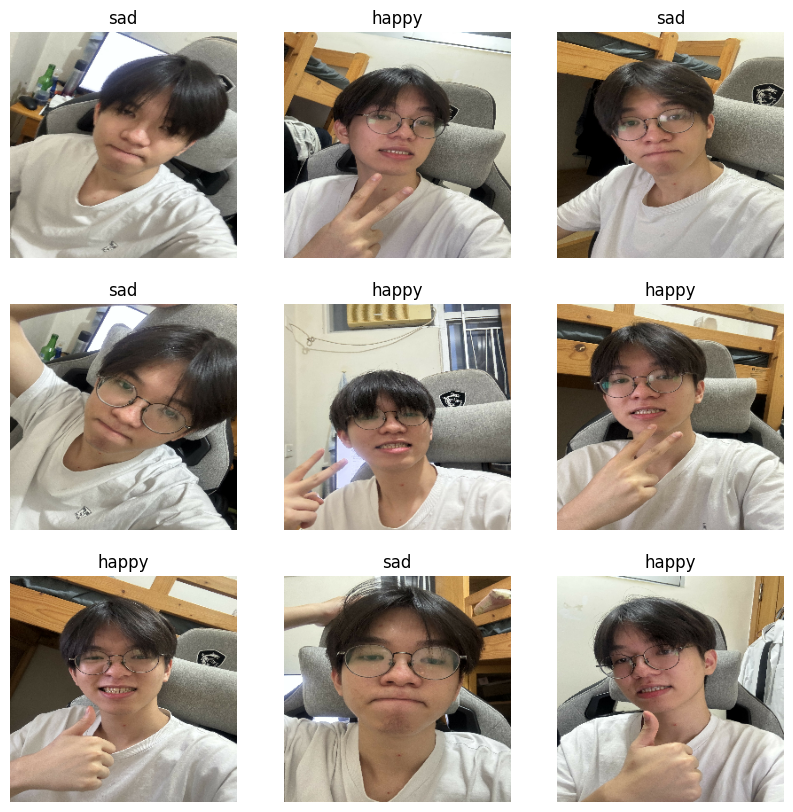

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [53]:
# Print class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Class names: ['happy', 'sad']


Since the image is already in 256 x 256 size, therefore no resize is needed.

But, it still has to preprocess the images for efficientnetV2 input and use the model that recommanded and change the output layer with 1 neuron using sigmoid activtion function instead of 50 neurons using softmax

In [54]:
import tensorflow as tf
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras import layers, models


# Preprocess images for EfficientNetV2 (no resizing needed since images are already 256x256)
def preprocess_image(image, label):
    image = efficientnet_v2.preprocess_input(image)
    return image, label

train_ds_preprocessed = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_preprocessed = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Add prefetch for performance
train_ds_preprocessed = train_ds_preprocessed.prefetch(tf.data.AUTOTUNE)
val_ds_preprocessed = val_ds_preprocessed.prefetch(tf.data.AUTOTUNE)

# Build model
base_model = efficientnet_v2.EfficientNetV2B0(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3)
)
base_model.trainable = False

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])
model = tf.keras.Sequential([
    data_augmentation,
    # Base model
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(1, activation="sigmoid")
])
#model.summary()
#history = compile_and_fit_model(model, X_train_preprocessed, y_train, epochs=10)

#print(history_final_values(history))

change the loss function to binary_crossentropy instead of categorical_crossentropy

In [55]:
model.compile(loss="binary_crossentropy",
              optimizer="adam", metrics=["acc"])

In [56]:
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=10, verbose=2)

Epoch 1/10
1/1 - 19s - 19s/step - acc: 0.3889 - loss: 0.7251 - val_acc: 1.0000 - val_loss: 0.6138
Epoch 2/10
1/1 - 6s - 6s/step - acc: 0.6667 - loss: 0.6046 - val_acc: 1.0000 - val_loss: 0.5449
Epoch 3/10
1/1 - 1s - 1s/step - acc: 0.8889 - loss: 0.4670 - val_acc: 1.0000 - val_loss: 0.4875
Epoch 4/10
1/1 - 1s - 986ms/step - acc: 0.7222 - loss: 0.5086 - val_acc: 1.0000 - val_loss: 0.4361
Epoch 5/10
1/1 - 1s - 1s/step - acc: 0.7778 - loss: 0.4624 - val_acc: 1.0000 - val_loss: 0.3896
Epoch 6/10
1/1 - 1s - 1s/step - acc: 0.9444 - loss: 0.3456 - val_acc: 1.0000 - val_loss: 0.3451
Epoch 7/10
1/1 - 1s - 1s/step - acc: 0.9444 - loss: 0.2945 - val_acc: 1.0000 - val_loss: 0.3061
Epoch 8/10
1/1 - 1s - 1s/step - acc: 1.0000 - loss: 0.2381 - val_acc: 1.0000 - val_loss: 0.2781
Epoch 9/10
1/1 - 1s - 916ms/step - acc: 0.9444 - loss: 0.2469 - val_acc: 1.0000 - val_loss: 0.2441
Epoch 10/10
1/1 - 2s - 2s/step - acc: 1.0000 - loss: 0.1669 - val_acc: 1.0000 - val_loss: 0.2137


{'acc': 1.0, 'loss': 0.1669, 'val_acc': 1.0, 'val_loss': 0.2137}


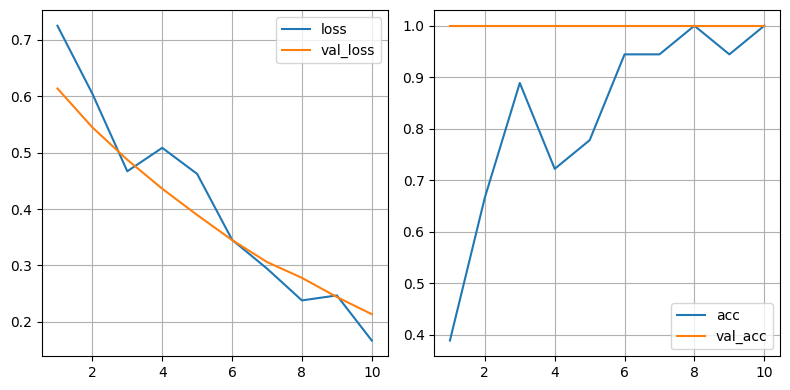

In [57]:
print(history_final_values(history))
plot_history(history)

Prediction using the val_ds

In [64]:
import numpy as np
y_probs = model.predict(val_ds)
print(y_probs.ravel().round(4))
y_pred = np.where(y_probs.ravel() < 0.5, 0, 1)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
[0.5953 0.1049 0.1509 0.7693 0.9112 0.125 ]
[1 0 0 1 1 0]


Plotting the prediction and the actual label

Number of images in val_ds: 6
Validation set accuracy: 1.0000


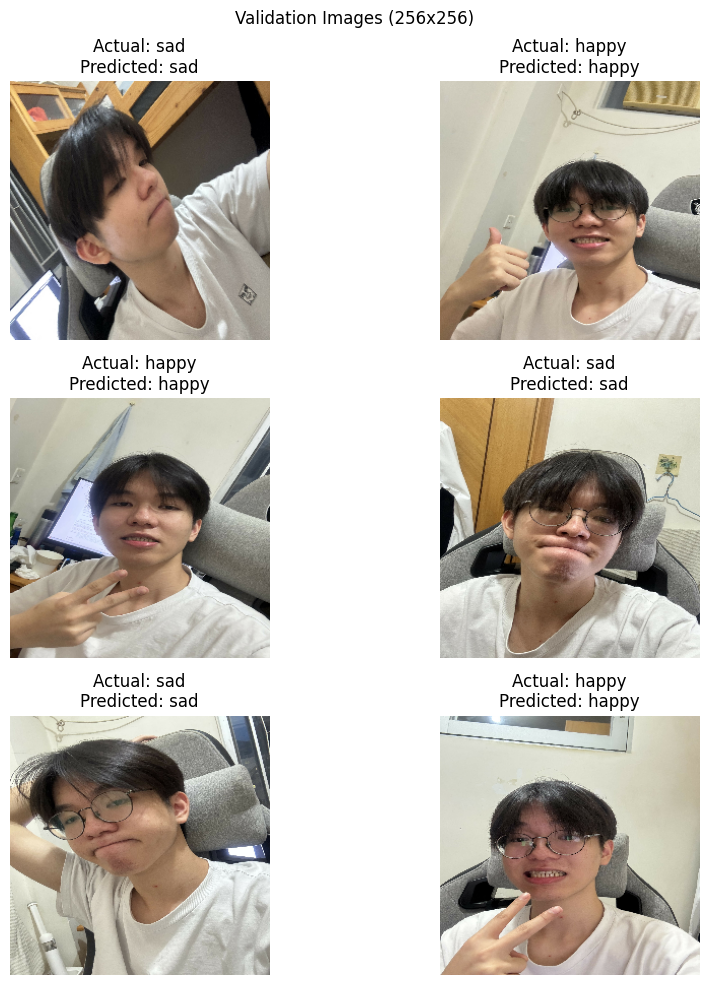

In [68]:
import matplotlib.pyplot as plt

# Collect all images and true labels from val_ds
val_images, val_labels = [], []
for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

# Concatenate all batches
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Verify the number of images in val_ds
print(f"Number of images in val_ds: {len(val_images)}")  # Should be 6

# Calculate accuracy
accuracy = np.mean(y_pred == val_labels)
print(f"Validation set accuracy: {accuracy:.4f}")

# Display all validation images with actual and predicted labels
plt.figure(figsize=(10, 10))
for i in range(len(val_images)):  # Display all 6 images
    ax = plt.subplot(3, 2, i + 1)  # 3x2 grid to fit 6 images
    plt.imshow(val_images[i].astype("uint8"))
    title = (f"Actual: {class_names[val_labels[i]]}\n"
             f"Predicted: {class_names[y_pred[i]]}")
    plt.title(title, color="k" if val_labels[i] == y_pred[i] else "r")
    plt.axis("off")
plt.suptitle("Validation Images (256x256)")
plt.tight_layout()
plt.show()